# Importación de dependencias

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import os
from PIL import Image
import time
import zipfile


2025-11-23 16:22:00.638887: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-23 16:22:01.505840: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-23 16:22:04.596717: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Cargar Dataset

In [2]:
def cargar_plantvillage(data_path):
    # Crea dos ImageDataGenerator: uno con aumentos (train) y otro sólo con reescalado (val).
    # Se usa validation_split para separar automáticamente parte del directorio como validación.
    train_datagen  = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.7, 1.3],
        channel_shift_range=0.2,
        fill_mode='nearest'
    )
    
    # Generador para validación: sin aumentos, sólo reescalado y mismo split.
    val_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )
    
    # flow_from_directory busca subcarpetas en data_path; cada subcarpeta es una clase.
    # 'subset' selecciona la porción correspondiente (training/validation) según validation_split.
    # Se fija la lista 'classes' para la elección de las clases de Tomate del dataset.
    train_generator = train_datagen .flow_from_directory(
        data_path,
        target_size=(224, 224),
        batch_size=32, 
        subset='training',
        class_mode='categorical',
        classes=['Tomato___Bacterial_spot', 'Tomato___Early_blight',
                'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot',
                 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot',
                 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus','Tomato___healthy']
    )
    
    # Generador de validación con el mismo conjunto de clases.
    val_generator = val_datagen.flow_from_directory(
        data_path,
        target_size=(224, 224),
        batch_size=32,
        subset='validation',
        class_mode='categorical',
        classes=['Tomato___Bacterial_spot', 'Tomato___Early_blight',
                'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot',
                 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot',
                 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus','Tomato___healthy']
    )

    return train_generator, val_generator

# Modelo

In [3]:
from tensorflow.keras.applications import MobileNetV2

CLASES_TOMATE = {
    0: 'Tomate_sano',
    1: 'Tomate_tizón_tardío',      # Late Blight
    2: 'Tomate_tizón_temprano',    # Early Blight  
    3: 'Tomate_mildiu',            # Powdery Mildew
    4: 'Tomate_mancha_bacteriana', # Bacterial Spot
    5: 'Tomate_moho_hojas',        # Leaf Mold
    6: 'Tomate_mancha_objetivo',   # Target Spot
    7: 'Tomate_mancha_secptoria',  # Septoria Leaf Spot
    8: 'Tomate_araña_roja',        # Spider Mites
    9: 'Tomate_virus_mosaico'      # Mosaic Virus
}

class SistemaCultivosColab:
    def __init__(self, input_shape=(224, 224, 3), num_classes=10):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = None
        self.history = None
        self.train_data = None
        self.val_data = None

    def crear_modelo_tomate(self):
        # Cargar MobileNetV2 pre-entrenado en ImageNet
        base_model = MobileNetV2(
            input_shape=self.input_shape,
            include_top=False,
            weights='imagenet'
        )

        # Congelar las capas del modelo base
        base_model.trainable = False

        # Construir el modelo sobre la base
        model = models.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dropout(0.3),
            layers.Dense(512, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(self.num_classes, activation='softmax')
        ])

        return model
    
    def descongelar_capas(self, unfreeze_layers=50):
        """Descongelar capas finales para fine-tuning"""
        if self.model is None:
            print("❌ Primero debe crear el modelo")
            return
            
        # Hacer la base del modelo entrenable
        base_model = self.model.layers[0]
        base_model.trainable = True
        
        # Descongelar solo las últimas capas
        for layer in base_model.layers[:-unfreeze_layers]:
            layer.trainable = False
            
        print(f"✅ Descongeladas las últimas {unfreeze_layers} capas")

    def compilar_entrenar(self, train_data, val_data, epochs_init=15, epochs_fine_tune=10):
        self.train_data = train_data
        self.val_data = val_data
        
        # FASE 1: Entrenar solo capas superiores
        print("🎯 FASE 1: Entrenando capas superiores...")

        # Crear modelo
        self.model = self.crear_modelo_tomate()

        # Compilar con optimizador mejorado
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )

        # Callbacks: early stopping para evitar sobreentrenar, ReduceLROnPlateau para ajustar LR,
        # y checkpoint para guardar el mejor modelo según val_accuracy.
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_accuracy', # Enfoque en generalización
                patience=5, # Balance eficiencia-convergencia
                restore_best_weights=True, # Garantiza mejor modelo
                mode='max' # Optimización directa de accuracy
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss', # Señal más estable que accuracy
                factor=0.2, # Reducción agresiva (80%)
                patience=3, # Espera moderada antes de reducir
            ),
            tf.keras.callbacks.ModelCheckpoint(
                'mejor_modelo_cultivos.h5',
                monitor='val_accuracy',
                save_best_only=True, # Solo mejores pesos
                mode='max' # Maximizar accuracy
            )
        ]

        print("🚀 Iniciando entrenamiento...")
        self.model.summary()
        history1 = self.model.fit(
            train_data,
            epochs=epochs_init,
            validation_data=val_data,
            callbacks=callbacks,
            verbose=1
        )
        
        # FASE 2: Fine-tuning
        print("\n🎯 FASE 2: Fine-tuning con capas descongeladas...")
        self.descongelar_capas(unfreeze_layers=50)
        
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # LR más bajo
            loss='categorical_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )
        
        history2 = self.model.fit(
            train_data,
            epochs=epochs_fine_tune,
            validation_data=val_data,
            callbacks=callbacks,
            verbose=1
        )
        
        # Combinar historiales
        self.history = self.combinar_historiales(history1, history2)
        

        return self.history

    def combinar_historiales(self, history1, history2):
        combined_history = {}
        for key in history1.history.keys():
            combined_history[key] = history1.history[key] + history2.history[key]
        return combined_history 
    
    def evaluar_modelo(self):
        if self.model is None:
            print("❌ Primero debe entrenar el modelo")
            return

        # Evaluación básica
        print("📊 Evaluando modelo...")
        test_loss, test_acc, test_precision, test_recall = self.model.evaluate(self.val_data)

        print(f"✅ Exactitud: {test_acc:.4f}")
        print(f"✅ Pérdida: {test_loss:.4f}")
        print(f"✅ Precisión: {test_precision:.4f}")
        print(f"✅ Recall: {test_recall:.4f}")

        # Predicciones para matriz de confusión
        y_pred = self.model.predict(self.val_data) # This might consume too much memory
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true = self.val_data.classes

        # Matriz de confusión
        self.plot_confusion_matrix(y_true, y_pred_classes)

        # Reporte de clasificación
        class_names = [CLASES_TOMATE[i] for i in range(self.num_classes)]
        print("\n📋 Reporte de Clasificación:")
        print(classification_report(y_true, y_pred_classes, target_names=class_names, digits=3))

        return test_acc

    def plot_confusion_matrix(self, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        class_names = [CLASES_TOMATE[i] for i in range(self.num_classes)]
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
                   xticklabels=class_names,
                   yticklabels=class_names)
        plt.title('Matriz de Confusión - Enfermedades del Tomate', fontsize=14, fontweight='bold')
        plt.ylabel('Diagnóstico Real', fontweight='bold')
        plt.xlabel('Diagnóstico Predicho', fontweight='bold')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

    def plot_training_history(self):
        if self.history is None:
            print("❌ No hay historial de entrenamiento")
            return

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Precisión
        axes[0, 0].plot(self.history['accuracy'], label='Entrenamiento')
        axes[0, 0].plot(self.history['val_accuracy'], label='Validación')
        axes[0, 0].set_title('Precisión del Modelo')
        axes[0, 0].set_ylabel('Precisión')
        axes[0, 0].set_xlabel('Época')
        axes[0, 0].legend()

        # Pérdida
        axes[0, 1].plot(self.history['loss'], label='Entrenamiento')
        axes[0, 1].plot(self.history['val_loss'], label='Validación')
        axes[0, 1].set_title('Pérdida del Modelo')
        axes[0, 1].set_ylabel('Pérdida')
        axes[0, 1].set_xlabel('Época')
        axes[0, 1].legend()

        # Precisión
        axes[1, 0].plot(self.history['precision'], label='Entrenamiento')
        axes[1, 0].plot(self.history['val_precision'], label='Validación')
        axes[1, 0].set_title('Precisión por Clase')
        axes[1, 0].set_ylabel('Precisión')
        axes[1, 0].set_xlabel('Época')
        axes[1, 0].legend()

        # Recall
        axes[1, 1].plot(self.history['recall'], label='Entrenamiento')
        axes[1, 1].plot(self.history['val_recall'], label='Validación')
        axes[1, 1].set_title('Recall del Modelo')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].set_xlabel('Época')
        axes[1, 1].legend()

        plt.tight_layout()
        plt.show()

## Predicción 

In [4]:
class PredictorCultivos:
    def __init__(self, modelo):
        self.modelo = modelo

    def probar_con_imagenes_validacion(self, val_data, num_imagenes=6):
        """Probar el modelo con imágenes de validación"""
        # Obtener algunas imágenes del conjunto de validación
        images, labels = next(iter(val_data))

        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.ravel()

        for i in range(min(num_imagenes, 6)):
            # Predecir
            pred = self.modelo.predict(tf.expand_dims(images[i], 0))
            pred_class = np.argmax(pred[0])
            true_class = np.argmax(labels[i])
            confianza = pred[0][pred_class]

            # Mostrar imagen
            axes[i].imshow(images[i])
            axes[i].set_title(f'Real: {true_class} | Pred: {pred_class}\nConf: {confianza:.2f}')
            axes[i].axis('off')

            # Color según si es correcto o no
            color = 'green' if pred_class == true_class else 'red'
            axes[i].spines['bottom'].set_color(color)
            axes[i].spines['top'].set_color(color)
            axes[i].spines['left'].set_color(color)
            axes[i].spines['right'].set_color(color)
            axes[i].spines['bottom'].set_linewidth(10)
            axes[i].spines['top'].set_linewidth(10)
            axes[i].spines['left'].set_linewidth(10)
            axes[i].spines['right'].set_linewidth(10)

        plt.tight_layout()
        plt.show()

# Implementación del proyecto

📂 Cargando dataset...
Found 14532 images belonging to 10 classes.
Found 3628 images belonging to 10 classes.
📊 Clases disponibles: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']
🔢 Número de clases: 10
📈 Imágenes de entrenamiento: 14532
📉 Imágenes de validación: 3628
🔄 Inicializando sistema de cultivos...
🎯 Iniciando entrenamiento...
🎯 FASE 1: Entrenando capas superiores...
🚀 Iniciando entrenamiento...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,049,802 (11.63 MB)

 Trainable params: 790,794 (3.02 MB)

 Non-trainable params: 2,259,008 (8.62 MB)

Epoch 1/15


2025-11-19 20:52:01.939450: I external/local_xla/xla/service/service.cc:163] XLA service 0x7c6c3c015790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-19 20:52:01.939486: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-11-19 20:52:02.149172: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-19 20:52:03.114391: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91500
2025-11-19 20:52:03.407550: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-19 20:52:03.

 82/455 ━━━━━━━━━━━━━━━━━━━━ 1:13 198ms/step - accuracy: 0.3867 - loss: 2.1854 - precision: 0.5107 - recall: 0.3004

2025-11-19 20:52:38.181191: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5409', 8 bytes spill stores, 8 bytes spill loads

2025-11-19 20:52:44.584598: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-19 20:52:44.817654: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.5651 - loss: 1.4336 - precision: 0.6789 - recall: 0.4870

2025-11-19 20:54:08.174331: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1261', 16 bytes spill stores, 16 bytes spill loads

2025-11-19 20:54:22.957348: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-19 20:54:23.207211: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-19 20:54:23.453693: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


455/455 ━━━━━━━━━━━━━━━━━━━━ 150s 279ms/step - accuracy: 0.6532 - loss: 1.0868 - precision: 0.7505 - recall: 0.5831 - val_accuracy: 0.7927 - val_loss: 0.5686 - val_precision: 0.8615 - val_recall: 0.7235 - learning_rate: 0.0010
Epoch 2/15
451/455 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.7243 - loss: 0.8162 - precision: 0.7982 - recall: 0.6591

455/455 ━━━━━━━━━━━━━━━━━━━━ 97s 213ms/step - accuracy: 0.7358 - loss: 0.7875 - precision: 0.8058 - recall: 0.6724 - val_accuracy: 0.8308 - val_loss: 0.5007 - val_precision: 0.8991 - val_recall: 0.7519 - learning_rate: 0.0010
Epoch 3/15
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.7535 - loss: 0.7273 - precision: 0.8286 - recall: 0.6912

455/455 ━━━━━━━━━━━━━━━━━━━━ 92s 203ms/step - accuracy: 0.7627 - loss: 0.7031 - precision: 0.8313 - recall: 0.7001 - val_accuracy: 0.8352 - val_loss: 0.4565 - val_precision: 0.8803 - val_recall: 0.7825 - learning_rate: 0.0010
Epoch 4/15
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.7753 - loss: 0.6636 - precision: 0.8381 - recall: 0.7134

455/455 ━━━━━━━━━━━━━━━━━━━━ 92s 203ms/step - accuracy: 0.7792 - loss: 0.6568 - precision: 0.8409 - recall: 0.7183 - val_accuracy: 0.8520 - val_loss: 0.4257 - val_precision: 0.9106 - val_recall: 0.7977 - learning_rate: 0.0010
Epoch 5/15
455/455 ━━━━━━━━━━━━━━━━━━━━ 90s 197ms/step - accuracy: 0.7814 - loss: 0.6289 - precision: 0.8448 - recall: 0.7254 - val_accuracy: 0.8506 - val_loss: 0.4253 - val_precision: 0.9024 - val_recall: 0.7977 - learning_rate: 0.0010
Epoch 6/15
452/455 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.7958 - loss: 0.6119 - precision: 0.8550 - recall: 0.7390

455/455 ━━━━━━━━━━━━━━━━━━━━ 92s 202ms/step - accuracy: 0.7956 - loss: 0.6043 - precision: 0.8535 - recall: 0.7395 - val_accuracy: 0.8569 - val_loss: 0.4071 - val_precision: 0.9030 - val_recall: 0.8109 - learning_rate: 0.0010
Epoch 7/15
454/455 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.7978 - loss: 0.6019 - precision: 0.8559 - recall: 0.7405

455/455 ━━━━━━━━━━━━━━━━━━━━ 91s 201ms/step - accuracy: 0.7998 - loss: 0.5940 - precision: 0.8562 - recall: 0.7419 - val_accuracy: 0.8597 - val_loss: 0.3960 - val_precision: 0.8951 - val_recall: 0.8230 - learning_rate: 0.0010
Epoch 8/15
454/455 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.8022 - loss: 0.5807 - precision: 0.8536 - recall: 0.7547

455/455 ━━━━━━━━━━━━━━━━━━━━ 92s 202ms/step - accuracy: 0.8002 - loss: 0.5860 - precision: 0.8544 - recall: 0.7512 - val_accuracy: 0.8616 - val_loss: 0.3971 - val_precision: 0.9081 - val_recall: 0.8112 - learning_rate: 0.0010
Epoch 9/15
455/455 ━━━━━━━━━━━━━━━━━━━━ 94s 205ms/step - accuracy: 0.8026 - loss: 0.5838 - precision: 0.8569 - recall: 0.7482 - val_accuracy: 0.8605 - val_loss: 0.4032 - val_precision: 0.9068 - val_recall: 0.8184 - learning_rate: 0.0010
Epoch 10/15
455/455 ━━━━━━━━━━━━━━━━━━━━ 95s 208ms/step - accuracy: 0.8062 - loss: 0.5615 - precision: 0.8596 - recall: 0.7552 - val_accuracy: 0.8545 - val_loss: 0.4140 - val_precision: 0.9006 - val_recall: 0.8068 - learning_rate: 0.0010
Epoch 11/15
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.8055 - loss: 0.5685 - precision: 0.8608 - recall: 0.7566

455/455 ━━━━━━━━━━━━━━━━━━━━ 92s 202ms/step - accuracy: 0.8128 - loss: 0.5490 - precision: 0.8649 - recall: 0.7636 - val_accuracy: 0.8718 - val_loss: 0.3712 - val_precision: 0.9189 - val_recall: 0.8280 - learning_rate: 2.0000e-04
Epoch 12/15
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.8184 - loss: 0.5390 - precision: 0.8685 - recall: 0.7699

455/455 ━━━━━━━━━━━━━━━━━━━━ 92s 201ms/step - accuracy: 0.8218 - loss: 0.5220 - precision: 0.8716 - recall: 0.7747 - val_accuracy: 0.8724 - val_loss: 0.3674 - val_precision: 0.9135 - val_recall: 0.8272 - learning_rate: 2.0000e-04
Epoch 13/15
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8284 - loss: 0.5112 - precision: 0.8741 - recall: 0.7839

455/455 ━━━━━━━━━━━━━━━━━━━━ 91s 201ms/step - accuracy: 0.8270 - loss: 0.5137 - precision: 0.8738 - recall: 0.7806 - val_accuracy: 0.8845 - val_loss: 0.3391 - val_precision: 0.9245 - val_recall: 0.8473 - learning_rate: 2.0000e-04
Epoch 14/15
455/455 ━━━━━━━━━━━━━━━━━━━━ 96s 210ms/step - accuracy: 0.8276 - loss: 0.5067 - precision: 0.8751 - recall: 0.7837 - val_accuracy: 0.8765 - val_loss: 0.3535 - val_precision: 0.9149 - val_recall: 0.8360 - learning_rate: 2.0000e-04
Epoch 15/15
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.8257 - loss: 0.5093 - precision: 0.8793 - recall: 0.7805

455/455 ━━━━━━━━━━━━━━━━━━━━ 95s 208ms/step - accuracy: 0.8329 - loss: 0.4968 - precision: 0.8799 - recall: 0.7861 - val_accuracy: 0.8875 - val_loss: 0.3330 - val_precision: 0.9206 - val_recall: 0.8501 - learning_rate: 2.0000e-04

🎯 FASE 2: Fine-tuning con capas descongeladas...
✅ Descongeladas las últimas 50 capas
Epoch 1/10


2025-11-19 21:16:23.702405: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:382] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


455/455 ━━━━━━━━━━━━━━━━━━━━ 136s 250ms/step - accuracy: 0.8312 - loss: 0.4973 - precision: 0.8714 - recall: 0.7949 - val_accuracy: 0.6020 - val_loss: 1.6613 - val_precision: 0.6270 - val_recall: 0.5830 - learning_rate: 1.0000e-04
Epoch 2/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 91s 200ms/step - accuracy: 0.9025 - loss: 0.2912 - precision: 0.9222 - recall: 0.8820 - val_accuracy: 0.7687 - val_loss: 0.8200 - val_precision: 0.7925 - val_recall: 0.7528 - learning_rate: 1.0000e-04
Epoch 3/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 90s 197ms/step - accuracy: 0.9216 - loss: 0.2308 - precision: 0.9355 - recall: 0.9089 - val_accuracy: 0.8393 - val_loss: 0.5225 - val_precision: 0.8518 - val_recall: 0.8299 - learning_rate: 1.0000e-04
Epoch 4/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9340 - loss: 0.1979 - precision: 0.9480 - recall: 0.9216

455/455 ━━━━━━━━━━━━━━━━━━━━ 91s 200ms/step - accuracy: 0.9370 - loss: 0.1876 - precision: 0.9487 - recall: 0.9257 - val_accuracy: 0.9267 - val_loss: 0.2160 - val_precision: 0.9348 - val_recall: 0.9214 - learning_rate: 2.0000e-05
Epoch 5/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 93s 204ms/step - accuracy: 0.9476 - loss: 0.1577 - precision: 0.9565 - recall: 0.9393 - val_accuracy: 0.9264 - val_loss: 0.2197 - val_precision: 0.9341 - val_recall: 0.9220 - learning_rate: 2.0000e-05
Epoch 6/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.9520 - loss: 0.1431 - precision: 0.9584 - recall: 0.9471

455/455 ━━━━━━━━━━━━━━━━━━━━ 93s 205ms/step - accuracy: 0.9522 - loss: 0.1398 - precision: 0.9595 - recall: 0.9467 - val_accuracy: 0.9490 - val_loss: 0.1523 - val_precision: 0.9544 - val_recall: 0.9468 - learning_rate: 2.0000e-05
Epoch 7/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 92s 201ms/step - accuracy: 0.9558 - loss: 0.1338 - precision: 0.9630 - recall: 0.9495 - val_accuracy: 0.9482 - val_loss: 0.1573 - val_precision: 0.9527 - val_recall: 0.9446 - learning_rate: 2.0000e-05
Epoch 8/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 91s 200ms/step - accuracy: 0.9564 - loss: 0.1245 - precision: 0.9637 - recall: 0.9497 - val_accuracy: 0.9369 - val_loss: 0.1871 - val_precision: 0.9416 - val_recall: 0.9333 - learning_rate: 2.0000e-05
Epoch 9/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 91s 200ms/step - accuracy: 0.9603 - loss: 0.1173 - precision: 0.9667 - recall: 0.9529 - val_accuracy: 0.9338 - val_loss: 0.2081 - val_precision: 0.9404 - val_recall: 0.9311 - learning_rate: 2.0000e-05
Epoch 10/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 92s 20

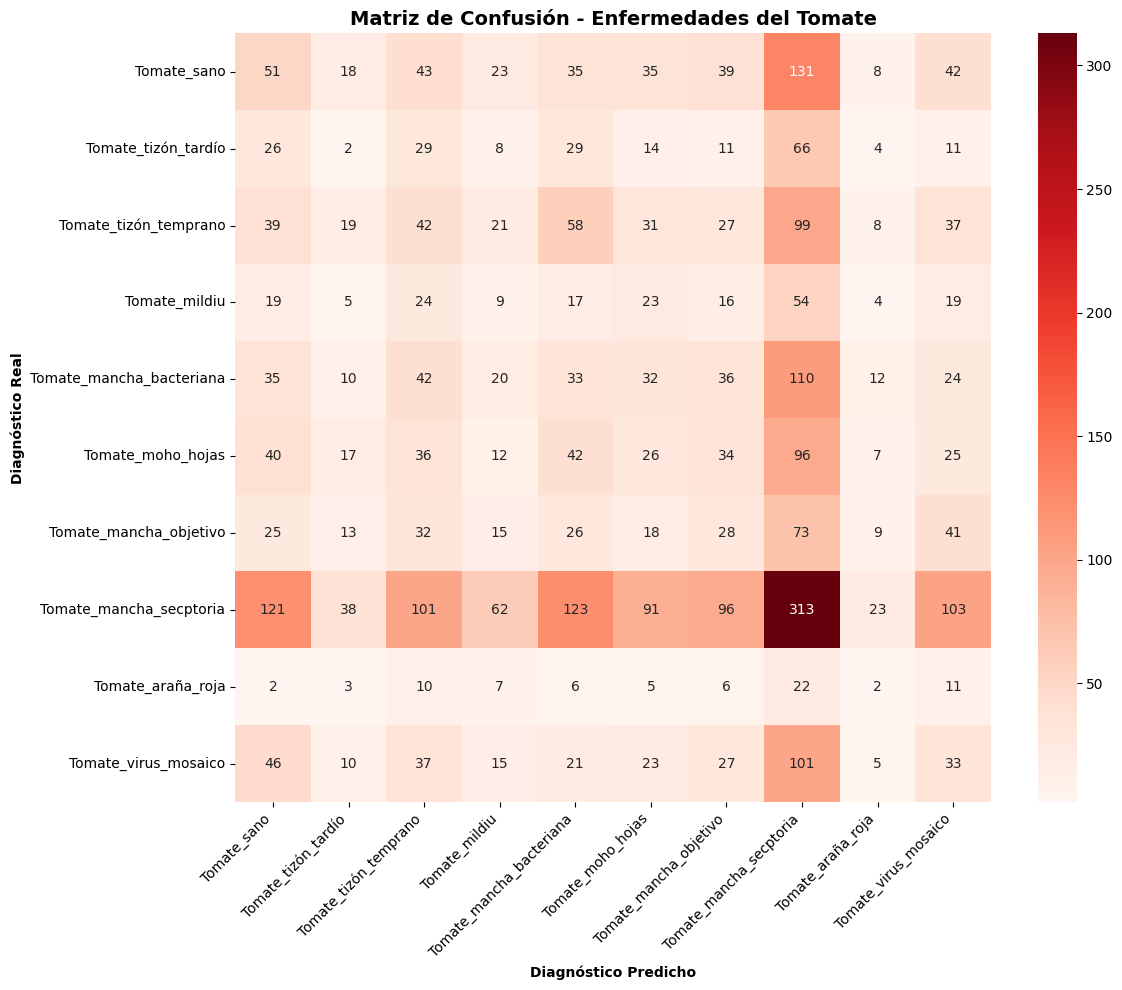


📋 Reporte de Clasificación:
                          precision    recall  f1-score   support

             Tomate_sano      0.126     0.120     0.123       425
     Tomate_tizón_tardío      0.015     0.010     0.012       200
   Tomate_tizón_temprano      0.106     0.110     0.108       381
           Tomate_mildiu      0.047     0.047     0.047       190
Tomate_mancha_bacteriana      0.085     0.093     0.089       354
       Tomate_moho_hojas      0.087     0.078     0.082       335
  Tomate_mancha_objetivo      0.087     0.100     0.093       280
 Tomate_mancha_secptoria      0.294     0.292     0.293      1071
       Tomate_araña_roja      0.024     0.027     0.026        74
    Tomate_virus_mosaico      0.095     0.104     0.099       318

                accuracy                          0.149      3628
               macro avg      0.097     0.098     0.097      3628
            weighted avg      0.148     0.149     0.148      3628

📈 Visualizando resultados...


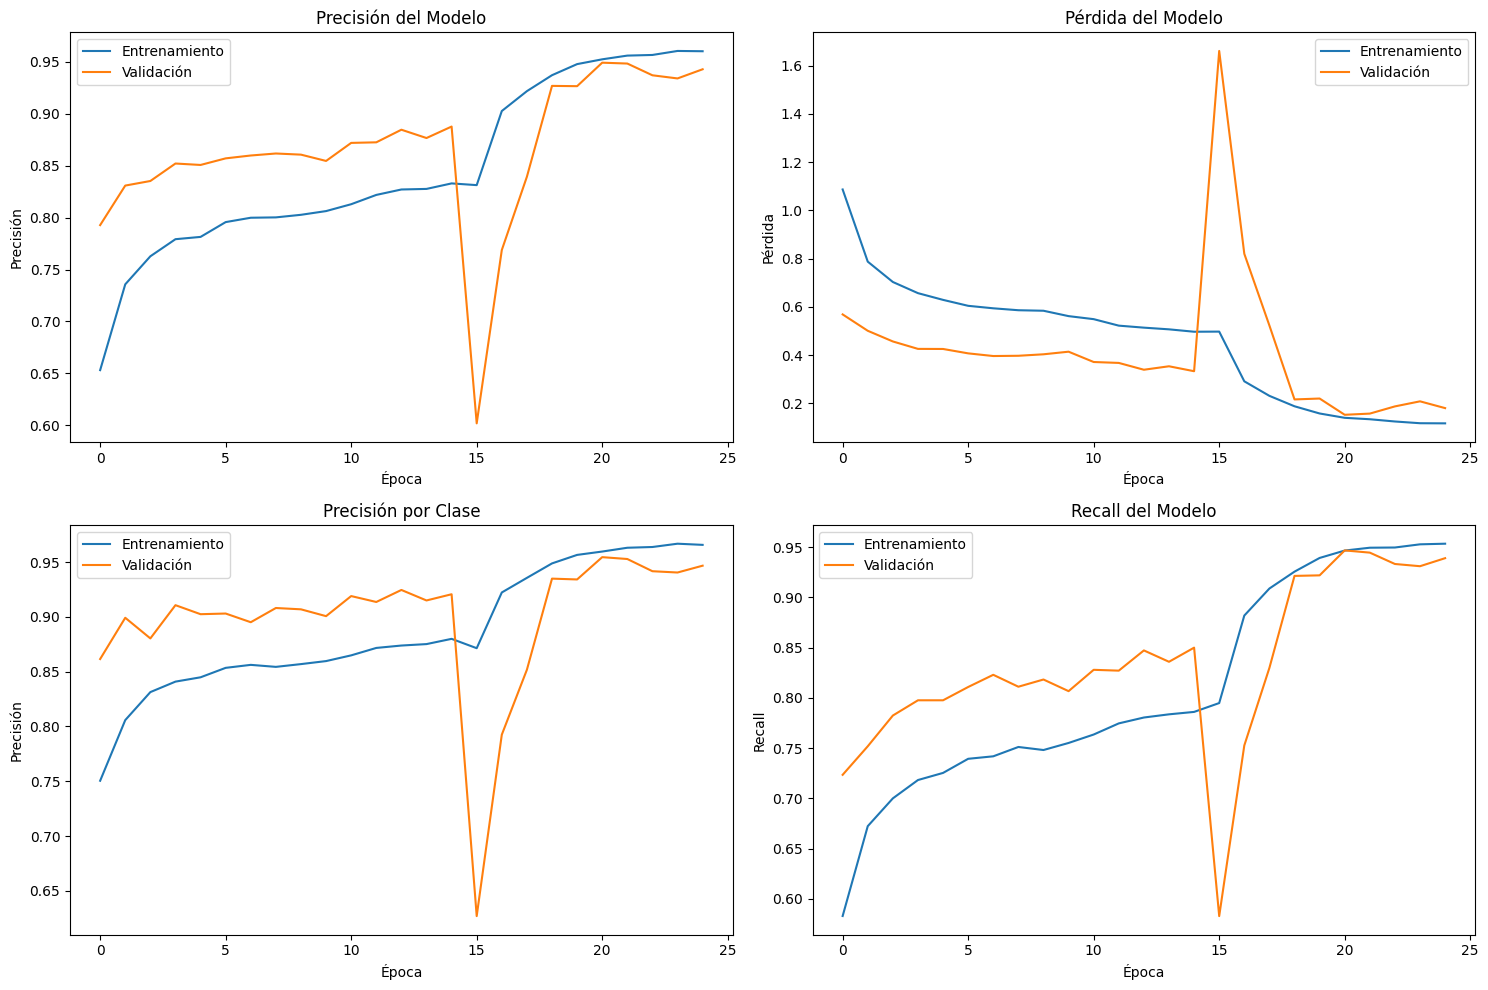

🔍 Probando con imágenes de validación...


2025-11-19 21:32:35.024280: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng3{k11=2} for conv (f32[1,576,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,576,14,14]{3,2,1,0}, f32[576,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=576, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]} is taking a while...
2025-11-19 21:32:35.060620: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.039023812s
Trying algorithm eng3{k11=2} for conv (f32[1,576,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,576,14,14]{3,2,1,0}, f32[576,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=576, custom_call_target="__cudnn$con

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


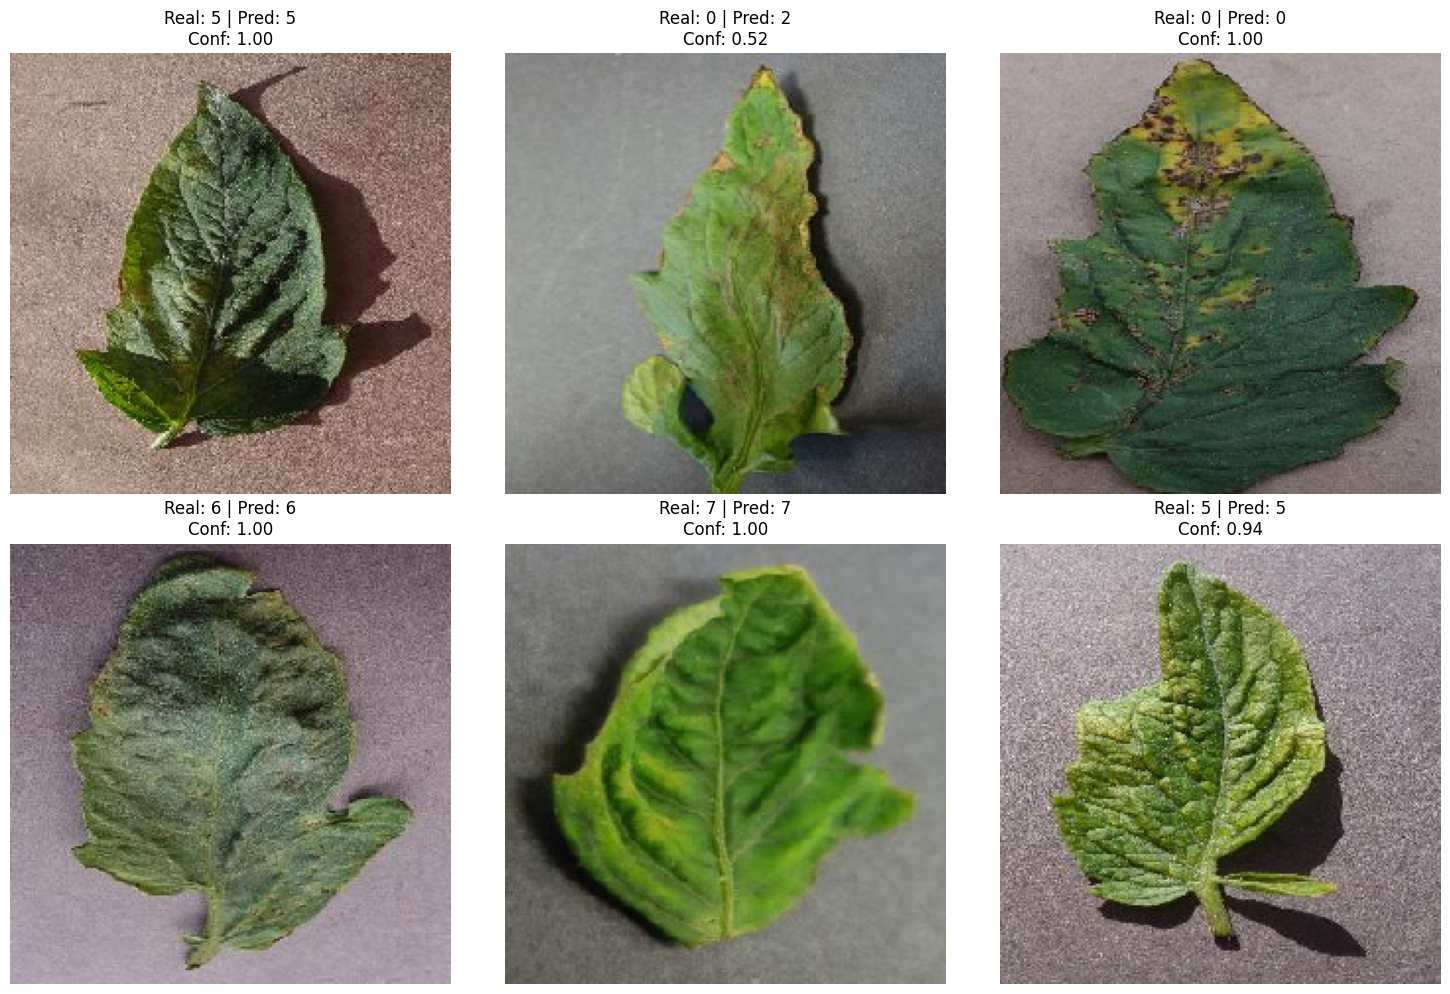

✅ ¡Sistema completado exitosamente!


In [ ]:
# 1. CARGAR DATOS (usando tu función)
print("📂 Cargando dataset...")
train_data, val_data = cargar_plantvillage('/home/luise/plantvillage dataset/color')

# Mostrar información del dataset
print(f"📊 Clases disponibles: {list(train_data.class_indices.keys())}")
print(f"🔢 Número de clases: {len(train_data.class_indices)}")
print(f"📈 Imágenes de entrenamiento: {train_data.samples}")
print(f"📉 Imágenes de validación: {val_data.samples}")

# 2. INICIALIZAR SISTEMA
print("🔄 Inicializando sistema de cultivos...")
sistema = SistemaCultivosColab(
    input_shape=(224, 224, 3),
    num_classes=len(train_data.class_indices)
)

# 3. ENTRENAR MODELO
print("🎯 Iniciando entrenamiento...")
start_time = time.time()
history = sistema.compilar_entrenar(train_data, val_data, epochs_init=15, epochs_fine_tune=10)
end_time = time.time()
print(f"⌛ Tiempo de entrenamiento: {end_time - start_time:.2f} segundos")

# 4. EVALUAR MODELO
print("📊 Evaluando modelo...")
sistema.evaluar_modelo()

# 5. VISUALIZAR RESULTADOS
print("📈 Visualizando resultados...")
sistema.plot_training_history()

# 6. CREAR PREDICTOR
predictor = PredictorCultivos(sistema.model)

# 7. PROBAR CON IMÁGENES DE VALIDACIÓN
print("🔍 Probando con imágenes de validación...")
predictor.probar_con_imagenes_validacion(val_data)

print("✅ ¡Sistema completado exitosamente!")